In [1]:
import folium
import numpy as np
import pandas as pd
from folium.plugins import HeatMap
from folium import plugins
from folium import GeoJson
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.colors as mcolors
import plotly.express as px
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
data_small_df = pd.read_csv("data/fullWithLocations_FINAL_small.csv")
data_large_df = pd.read_csv("data/fullWithLocations_FINAL_large.csv")

In [3]:
group_small = [
    "AIRMASS", "ALLSKY_SFC_SW_DWN", "ALLSKY_SFC_UVA", "ALLSKY_SFC_UVB",
    "ALLSKY_SFC_UV_INDEX", "CLOUD_AMT", "CLOUD_AMT_DAY", "CLOUD_AMT_NIGHT",
    "CLRSKY_DAYS", "MIDDAY_INSOL", "PSH", "PW"
]

group_large = [
    " EVLAND", "GWETPROF", "GWETROOT", "GWETTOP", "PRECSNO", "PRECTOTCORR",
    "QV2M", "RH2M", "RHOA", "T10M", "T10M_MAX", "T10M_MIN", "T2M",
    "T2M_MAX", "T2M_MIN", "TO3", "TS", "TSOIL1", "TSOIL2", "TSOIL3",
    "TSOIL4", "TSOIL5", "TSOIL6", "TS_MAX", "TS_MIN", "WD2M", "WD50M",
    "WS2M", "WS2M_MAX", "WS2M_MIN", "WS50M", "WS50M_MAX", "WS50M_MIN", "Z0M"
]

In [4]:


year_selector = widgets.IntText(
    value=data_large_df['YEAR'].min(),
    description="Year:",
    min=data_large_df['YEAR'].min(),
    max=data_large_df['YEAR'].max()
)

attribute_options = group_small + group_large
attribute_selector = widgets.Dropdown(
    options=attribute_options,
    value="PRECTOTCORR",
    description="Attribute:"
)

attribute_button = widgets.Button(description="Update Attribute")

agg_mode_selector = widgets.Dropdown(
    options=["Week", "Month", "Chapter","DOY"],
    value="Week",
    description="Select By:"
)

agg_period_selector = widgets.IntText(
    value=26,
    description="Period:",
    min=1,
    max=366
)

aggregated_button = widgets.Button(description="Show Map")
save_button = widgets.Button(description="Save as HTML")

def display_aggregated_map(year, attribute, agg_mode, period, save=False):
    clear_output(wait=True)
    display(year_selector,  attribute_selector, 
            agg_mode_selector, agg_period_selector,
            attribute_button, aggregated_button, save_button)
    
    if attribute in group_small:
        df = data_small_df
    elif attribute in group_large:
        df = data_large_df
    else:
        print("Attribute not found!")
        return
    
    
    df_year = df[df['YEAR'] == year].copy()
    if df_year.empty:
        print(f"No data available for Year {year}")
        return
    
    if agg_mode == "Week":
        df_agg = df_year[df_year['Week'] == period]
        title_period = f"Week: {period}"
    elif agg_mode == "Month":
        df_agg = df_year[df_year['Month'] == period]
        title_period = f"Month: {period}"
    elif agg_mode == "Chapter":
        df_agg = df_year[df_year['Chapter'] == period]
        title_period = f"Chapter: {period}"
    elif agg_mode=="DOY":
        df_agg=df_year[df_year['DOY'] == period] 
        title_period =f"DOY {period}"         
    else:
        df_agg = df_year
        title_period = "All Days"
    
    if( df_agg.empty ):
        print(f"No data available for {agg_mode} {period} in Year {year}")
        return
    
    group_cols = ['LAT', 'LON']
    agg_df = df_agg.groupby(group_cols)[attribute].mean().reset_index()
    
    
    min_value = agg_df[attribute].min()
    max_value = agg_df[attribute].max()
    
    agg_df['Intensity'] = agg_df[attribute].apply(
        lambda x: (x - min_value) / (max_value - min_value) if max_value > min_value else agg_df[attribute].min() 
        )
    
    egypt_map = folium.Map(location=[26.8206, 30.8025], zoom_start=6)
    title_html = '<h3 align="center" style="font-size:20px"><b>Year: {} - {} - Attribute: {}</b></h3>'.format(year, title_period, attribute)
    egypt_map.get_root().html.add_child(folium.Element(title_html))
    heatmap_data = agg_df[agg_df['Intensity'] > 0][['LAT', 'LON', 'Intensity']].values.tolist()

    HeatMap(heatmap_data, radius=10, blur=15, max_zoom=10).add_to(egypt_map)
    

    colors = ["black","blue", "cyan", "yellow", "orange", "red"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

    quantiles = np.quantile(agg_df["Intensity"], [0.01,0.55,0.7, 0.85, 0.95, 1.0])

    def intensity_to_color(intensity):
        """Map intensity to color based on quantile ranges."""
        if intensity <= quantiles[0]:
            return mcolors.to_hex(colors[0])  
        elif intensity <= quantiles[1]:
            return mcolors.to_hex(colors[1])  
        elif intensity <= quantiles[2]:
            return mcolors.to_hex(colors[2])  
        elif intensity <= quantiles[3]:
            return mcolors.to_hex(colors[3])  
        elif intensity <= quantiles[4]:
            return mcolors.to_hex(colors[4])  
        else:
            return mcolors.to_hex(colors[5])  

    
    for _, row in agg_df.iterrows():
        if(row["Intensity"]>0):
            tooltip_text = f"{attribute}: {row[attribute]:.5f}"
            if 'City' in agg_df.columns:
                tooltip_text = f"City: {row['City']}, " + tooltip_text
            folium.CircleMarker(
                location=[row['LAT'], row['LON']],
                radius=7,
                color=intensity_to_color(row['Intensity']),
                fill=True,
                fill_color=intensity_to_color(row['Intensity']),
                fill_opacity=0.6,
                tooltip=tooltip_text
            ).add_to(egypt_map)
    def Save():
        filename = f"Aggregated_{attribute}_{year}_{agg_mode}{period}.html"
        egypt_map.save(filename)
        print(f"Heatmap saved as {filename}")       
    save_button.on_click(Save)
        
    display(egypt_map)


def on_aggregated_button_click(b):
    display_aggregated_map(year_selector.value, attribute_selector.value, 
                            agg_mode_selector.value, agg_period_selector.value)

aggregated_button.on_click(on_aggregated_button_click)

display(year_selector,  attribute_selector, 
        agg_mode_selector, agg_period_selector,
        attribute_button, aggregated_button, save_button)


IntText(value=2019, description='Year:')

Dropdown(description='Attribute:', index=17, options=('AIRMASS', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UVA', 'ALLSK…

Dropdown(description='Select By:', options=('Week', 'Month', 'Chapter', 'DOY'), value='Week')

IntText(value=26, description='Period:')

Button(description='Update Attribute', style=ButtonStyle())

Button(description='Show Map', style=ButtonStyle())

Button(description='Save as HTML', style=ButtonStyle())

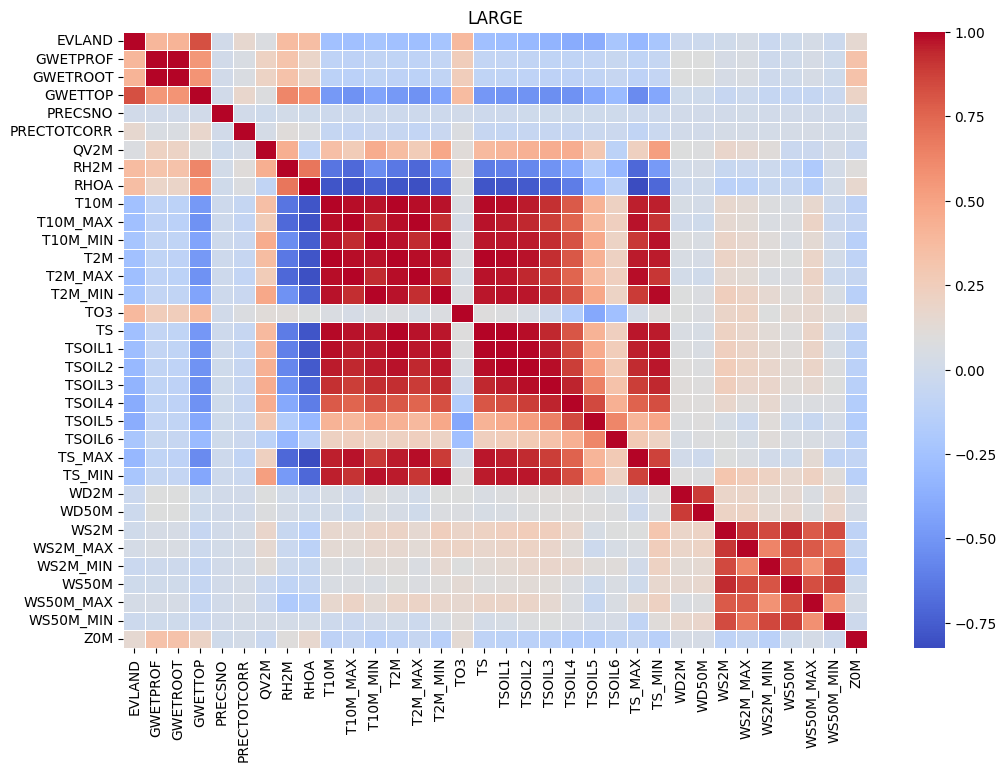

In [5]:
%matplotlib inline

group_small = [
    "AIRMASS", "ALLSKY_SFC_SW_DWN", "ALLSKY_SFC_UVA", "ALLSKY_SFC_UVB",
    "ALLSKY_SFC_UV_INDEX", "CLOUD_AMT", "CLOUD_AMT_DAY", "CLOUD_AMT_NIGHT",
    "CLRSKY_DAYS", "MIDDAY_INSOL", "PSH", "PW"
]
group_large = [
    "EVLAND", "GWETPROF", "GWETROOT", "GWETTOP", "PRECSNO", "PRECTOTCORR",
    "QV2M", "RH2M", "RHOA", "T10M", "T10M_MAX", "T10M_MIN", "T2M",
    "T2M_MAX", "T2M_MIN", "TO3", "TS", "TSOIL1", "TSOIL2", "TSOIL3",
    "TSOIL4", "TSOIL5", "TSOIL6", "TS_MAX", "TS_MIN", "WD2M", "WD50M",
    "WS2M", "WS2M_MAX", "WS2M_MIN", "WS50M", "WS50M_MAX", "WS50M_MIN", "Z0M"
]
df_large=pd.read_csv("data/fullWithLocations_FINAL_large.csv")
df_small=pd.read_csv("data/fullWithLocations_FINAL_small.csv")

corr_small = df_small[group_small].corr()
corr_large = df_large[group_large].corr()

def plot_heatmap(corr_matrix, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title(title)
    plt.show()

D=plot_heatmap(corr_large,"LARGE")




# full Analysis Site For all Attributes

In [6]:
file_path = "data/fullWithLocations_FINAL_large.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

df = pd.read_csv(file_path)

profile = ProfileReport(df, title="Exploratory Data Analysis Report", explorative=True, minimal=True)

output_dir = "reports"
os.makedirs(output_dir, exist_ok=True)


report_path = os.path.join(output_dir, "/EDA_Report.html")
profile.to_file(report_path)

try:
    profile.to_notebook_iframe()
except Exception as e:
    print(f"Notebook display failed: {e}")

print(f"EDA report saved successfully at: {report_path}")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

EDA report saved successfully at: /EDA_Report.html


In [7]:
df_large = pd.read_csv("data/fullWithLocations_FINAL_large.csv")


group_large = [
    "EVLAND", "GWETPROF", "GWETROOT", "GWETTOP", "PRECSNO", "PRECTOTCORR",
    "QV2M", "RH2M", "RHOA", "T10M", "T10M_MAX", "T10M_MIN", "T2M",
    "T2M_MAX", "T2M_MIN", "TO3", "TS", "TSOIL1", "TSOIL2", "TSOIL3",
    "TSOIL4", "TSOIL5", "TSOIL6", "TS_MAX", "TS_MIN", "WD2M", "WD50M",
    "WS2M", "WS2M_MAX", "WS2M_MIN", "WS50M", "WS50M_MAX", "WS50M_MIN", "Z0M"
]
corr_large = df_large[group_large].corr()
corr_matrix = corr_large.stack().reset_index()

corr_matrix.columns = ['Feature1', 'Feature2', 'Correlation']
fig = px.density_heatmap(
    corr_matrix, x="Feature1", y="Feature2", z="Correlation",
    color_continuous_scale="RdBu",  
    title="Interactive Correlation Heatmap"
)

fig.update_layout(
    width=1000,
    height=800
)

fig.show()
corr_matrix.head()


Feature1  Feature2  Correlation
0   EVLAND    EVLAND     1.000000
1   EVLAND  GWETPROF     0.395326
2   EVLAND  GWETROOT     0.409393
3   EVLAND   GWETTOP     0.822978
4   EVLAND   PRECSNO     0.002746

In [8]:

corr_large = df_large[group_large].corr()
corr_matrix = corr_large.stack().reset_index()
corr_matrix.columns = ['Feature1', 'Feature2', 'Correlation']

corr_matrix = corr_matrix[corr_matrix["Feature1"] < corr_matrix["Feature2"]]
strong_relations = corr_matrix[(corr_matrix["Correlation"].abs() > 0.5)]
display(strong_relations)
strong_relations.to_csv("data/Strong_correlations.csv")

Feature1   Feature2  Correlation
3        EVLAND    GWETTOP     0.822978
36     GWETPROF   GWETROOT     0.998455
37     GWETPROF    GWETTOP     0.554756
71     GWETROOT    GWETTOP     0.571413
109     GWETTOP       RH2M     0.623162
...         ...        ...          ...
1017   WS2M_MIN  WS50M_MAX     0.579201
1018   WS2M_MIN  WS50M_MIN     0.856464
1051      WS50M  WS50M_MAX     0.835862
1052      WS50M  WS50M_MIN     0.879082
1086  WS50M_MAX  WS50M_MIN     0.585187

[137 rows x 3 columns]